### **Use this Notebook on Google Colab Free GPU**
Go to Google Drive, upload this notebook and dataset folders. Rigth click notebook, choose **Open with -> Google Colab**
<br>
To activate GPU in Colab, go to **Runtime -> Change Runtime Type**. Under **Hardware accelerator** choose **GPU**

### Connect to Google Drive to access Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/COVID-19 Detection using CT Scan Images'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/COVID-19 Detection using CT Scan Images


In [2]:
%ls

'Copy of RESNETold.ipynb'              resnet_withoutgen.h5
'Copy of Xception CT Formated.ipynb'  'RESNSET accurate.ipynb'
'Copy of Xceptionold.ipynb'            vgg.h5
 data/                                 VGG.ipynb
 images/                              'VGG old config 70% avgpool2D.ipynb'
 inception_ct.h5                       VGG_RESNET.h5
 inceptionv3_299.h5                   'VGG RESNET SETTINGS.ipynb'
 inceptionv3_299.hdf5                  VGG_RESNSET.hdf5
 inceptionv3.h5                        vggweights.hdf5
'InceptionV3 Real 299.ipynb'           xception1.h5
 inceptionv3_real.h5                   xception1.hdf5
 inceptionv3_real.hdf5                 xception2_rohilrg.h5
'InceptionV3 Real.ipynb'              'Xception 93%.ipynb'
 inception_weights_ct.hdf5            'Xception CT Formated.ipynb'
 resnet2_rohilrg.h5                    xception_formatted.h5
 resnet50.h5                           xception_gen.h5
 resnet50weights.hdf5                  Xception.ipynb
 RESNET.ipynb  

### Import all dependencies

In [3]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Define Few Parameters

In [0]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = 'data/ct/CT_COVID'
noncovid_path = 'data/ct/CT_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [64]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['data/CT_COVID/2020.03.22.20034041-p18-92-1.png', 'data/CT_COVID/2020.03.25.20037721-p27-172.png', 'data/CT_COVID/2020.02.25.20027763-p15-53%1.png', 'data/CT_COVID/2020.03.08.20031658-p15-106.png', 'data/CT_COVID/Comparison-of-different-samples-for-2019-novel-cor_2020_International-Journa-p2-21%10.png']
Total Count:  349
First 5 NonCovid Files:  ['data/CT_NonCOVID/782.png', 'data/CT_NonCOVID/174.png', 'data/CT_NonCOVID/781.png', 'data/CT_NonCOVID/1310.png', 'data/CT_NonCOVID/663.png']
Total Count:  397


### Fetch Images and Class Labels from Files (This might take a while)

In [0]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per kera
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') # append class label
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

### Visualize First 40 Images from Data set

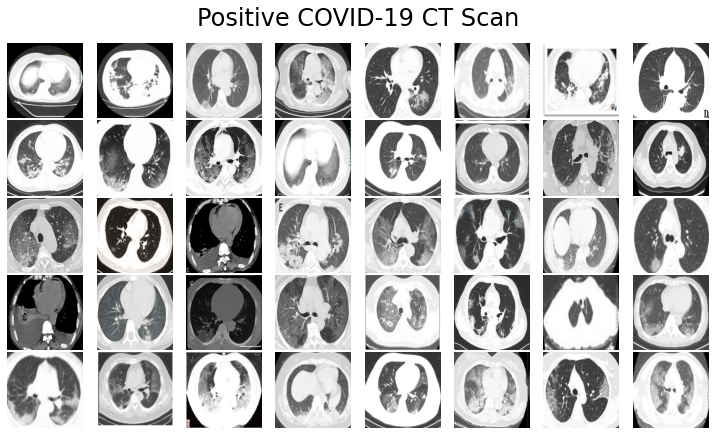

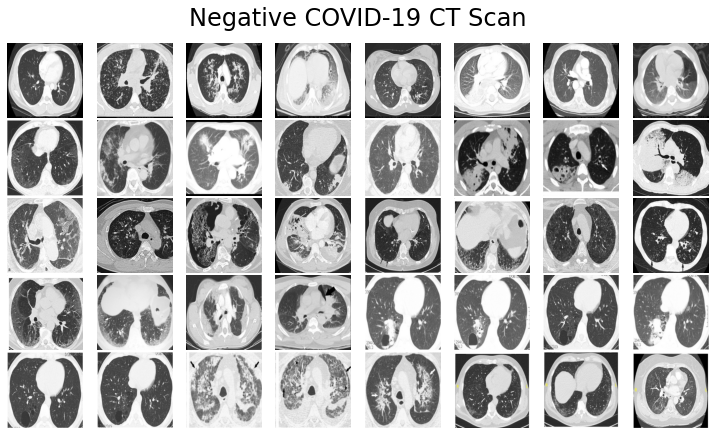

In [66]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [0]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [0]:
# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

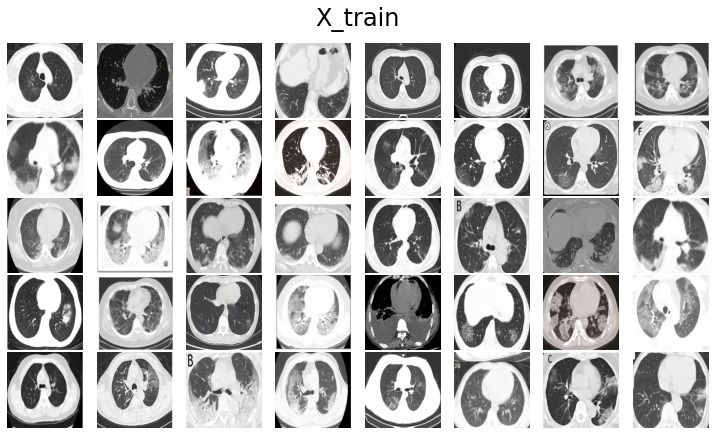

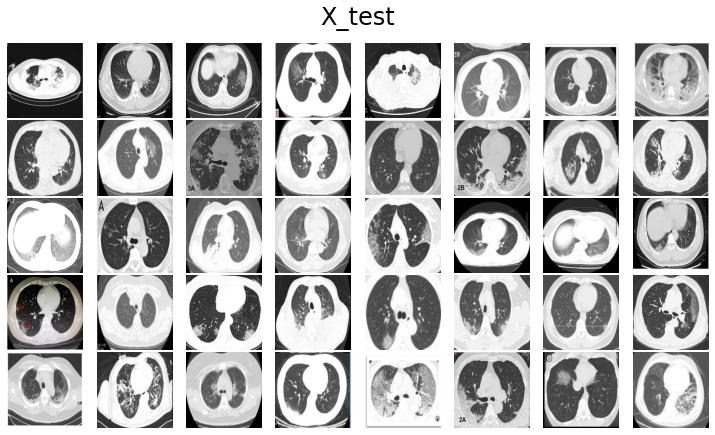

In [69]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building and Visualizing model**

In [11]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

87916544/87910968 [==============================] - 1s 0us/step


In [12]:
# Visualize Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### **Image Augmentation**
#### To train on images at different positions, angles, flips, etc

In [0]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [14]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
19/18 [==============================] - 8s 417ms/step - loss: 3.5650 - accuracy: 0.5705 - val_loss: 0.9084 - val_accuracy: 0.7467
Epoch 2/500
19/18 [==============================] - 6s 319ms/step - loss: 1.6664 - accuracy: 0.6829 - val_loss: 1.0046 - val_accuracy: 0.7533
Epoch 3/500
19/18 [==============================] - 6s 316ms/step - loss: 1.4779 - accuracy: 0.7148 - val_loss: 0.8212 - val_accuracy: 0.7600
Epoch 4/500
19/18 [==============================] - 6s 318ms/step - loss: 1.2434 - accuracy: 0.7349 - val_loss: 0.7627 - val_accuracy: 0.8067
Epoch 5/500
19/18 [==============================] - 6s 330ms/step - loss: 1.4166 - accuracy: 0.7450 - val_loss: 0.8440 - val_accuracy: 0.7667
Epoch 6/500
19/18 [==============================] - 6s 332ms/step - loss: 2.2820 - accuracy: 0.6829 - val_loss: 1.6615 - val_accuracy: 0.7200
Epoch 7/500
19/18 [==============================] - 6s 323ms/step - loss: 1.3284 - accuracy: 0.7517 - val_loss: 1.1268 - val_accuracy: 0.7333

In [0]:
# Save Model and Weights
model.save('inception_ct.h5')
model.save_weights('inception_weights_ct.hdf5')

In [0]:
# Load saved model
model = load_model('inception_ct.h5')

### **Making Predicions**

In [0]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

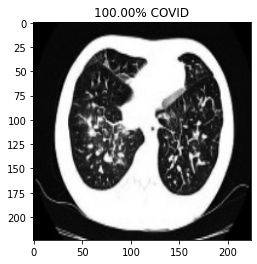

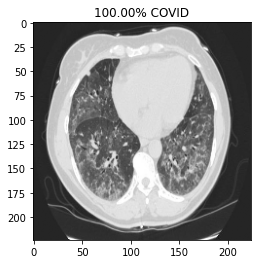

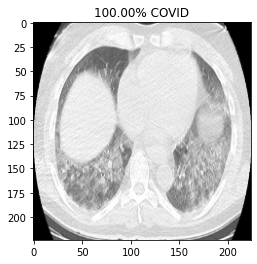

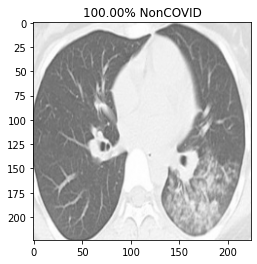

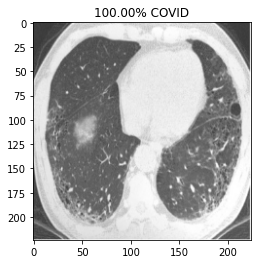

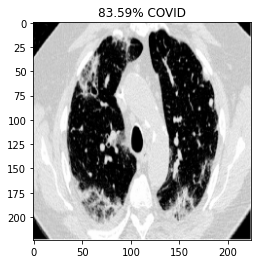

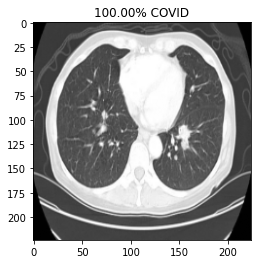

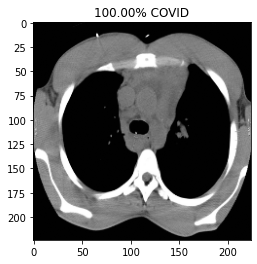

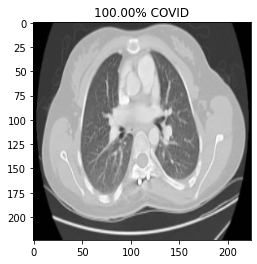

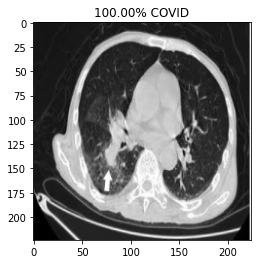

In [72]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.style.reload_library
  plt.imshow(X_test[index])
  plt.show()

In [0]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

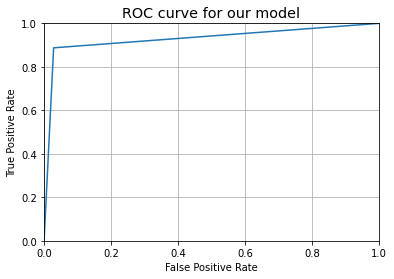

In [74]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


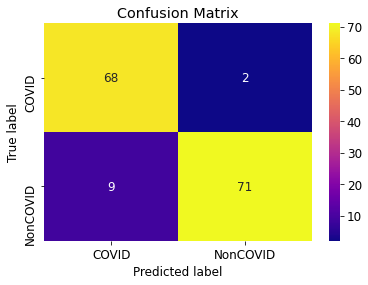

Confusion Matrix with Normalized Values


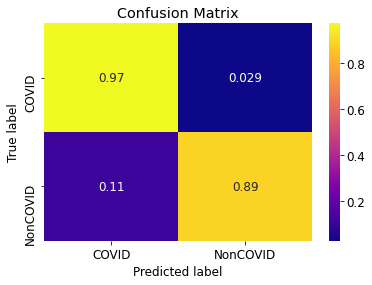

In [75]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.88      0.97      0.93        70
           1       0.97      0.89      0.93        80

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



### **Accuracy and Loss Plots**

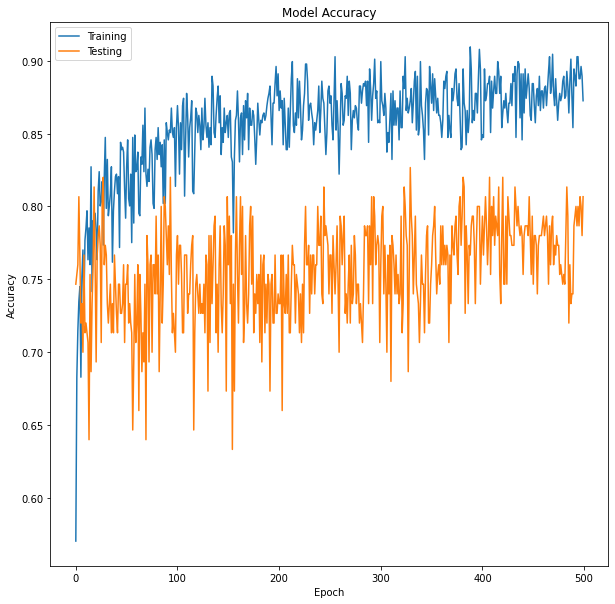

In [61]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_accuracy.png')
plt.show()


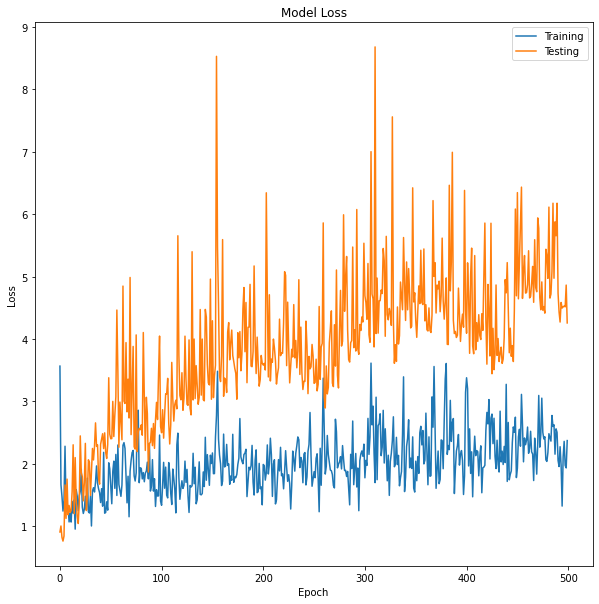

In [62]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_loss.png')
plt.show()